In [808]:
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

### Fistly, lets read the file 

In [811]:
df = pd.read_excel('/Users/vladimiregorov/Downloads/Online Retail 2.xlsx')
df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


### Here it is. The following info columns represent : 
- `InvoiceNo` - the id of the purchase
- `StockCode` - the id of the purchased good
- `Description` - the description of the purchased good
- `Quantity` - the quantity of the purchased good
- `InvoiceDate` - the date of the purchase
- `UnitPrice` - the price of the purchased good per unit
- `CustomerID` - the id of the Customer
- `Country` - the country from which the purchase was maid

I do think that there is no reason for us to grab the `Description` data with us. Lets get rid of it

In [812]:
df = df.drop(columns=('Description'))
df.shape

(541909, 7)

### Data Cleaning

Lets see how many `null` values do we have : 

In [814]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Lets drop rows where `CustomerID` is null

In [815]:
df.dropna(inplace=True)
df.shape

(406829, 7)

### Let's find the retention 

Firstly, lets find out the types of our variables : 

In [816]:
df.dtypes

InvoiceNo              object
StockCode              object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

Lets make the `date` column into the format `%Y-%m-%d`

In [831]:
df['date'] = df['InvoiceDate'].apply(lambda x: datetime.strftime(x, '%Y-%m-%d'))
df['date'] = df['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
df['date'].head(2)

0   2010-12-01
1   2010-12-01
Name: date, dtype: datetime64[ns]

Let's find the `first day` for each user : 

In [833]:
first_sale = df.groupby('CustomerID').agg({'date' : 'min'}).reset_index()
first_sale = first_sale.rename(columns=({'date' : 'first'}))
first_sale.head(3)

,CustomerID,first
0,12346.0,2011-01-18
1,12347.0,2010-12-07
2,12348.0,2010-12-16


And merge it with the main table : 

In [834]:
df = df.merge(first_sale, how='left', left_on='CustomerID', right_on='CustomerID')

Now we have the `following` table : 

In [836]:
df.head(2)

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date,first
0,536365,85123A,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01
1,536365,71053,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01


With the `following columns` and `types` of the data : 

In [837]:
df.dtypes

InvoiceNo              object
StockCode              object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
date           datetime64[ns]
first          datetime64[ns]
dtype: object

In [838]:
df['date'] = pd.to_datetime(df['date'])
df['first'] = pd.to_datetime(df['first'])

Lets find the period for each user. It is needed for calculating the `retention` : 

In [840]:
dif = ((df['date'].dt.year - df['first'].dt.year) * 12 + (df['date'].dt.month - df['first'].dt.month))
dif = dif.reset_index()
dif = dif.rename(columns=({0 : 'per'}))
dif.head(2)

,index,per
0,0,0
1,1,0


Lets add the index columns for the main `df` to merge it with `dif` easily

In [841]:
df = df.reset_index()

In [842]:
df.head(3)

,index,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date,first
0,0,536365,85123A,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01
1,1,536365,71053,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01
2,2,536365,84406B,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,2010-12-01


Finaly, lets merge them : 

In [847]:
df = df.merge(dif, how='left', left_on='index', right_on='index')
df.head(3)

,index,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date,first,per
0,0,536365,85123A,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01,0
1,1,536365,71053,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,0
2,2,536365,84406B,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,2010-12-01,0


Let's add the `first_month` and `month` to make it more convenient for us : 

In [848]:
df['first_month'] = df['first'].apply(lambda x : datetime.strftime(x, '%Y-%m'))
df['month'] = df['date'].apply(lambda x : datetime.strftime(x, '%Y-%m'))

What we have : 

In [850]:
df.head(3)

,index,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date,first,per,first_month,month
0,0,536365,85123A,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01,0,2010-12,2010-12
1,1,536365,71053,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,0,2010-12,2010-12
2,2,536365,84406B,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,2010-12-01,0,2010-12,2010-12


Lets creat the pre-final dataframe `result` and group our data by the fist month and the period : 

In [853]:
result = df.groupby(['first_month','per']).agg({'InvoiceNo' : 'nunique'}).reset_index()
result.head()

,first_month,per,InvoiceNo
0,2010-12,0,1708
1,2010-12,1,689
2,2010-12,2,579
3,2010-12,3,753
4,2010-12,4,611


Great, what we nee to do now is to find the `maximum number` for each `cohort` in order to calculate the `%` for `retention` : 

In [854]:
max = result.groupby('first_month').agg({'InvoiceNo' : 'max'}).reset_index()
max = max.rename(columns=({'InvoiceNo' : 'max'}))
max.head()

,first_month,max
0,2010-12,1708
1,2011-01,547
2,2011-02,474
3,2011-03,548
4,2011-04,386


Awesome! Let's `merge` them together and calculate the `percentage`! 

In [856]:
result = result.merge(max)
result['percent'] = result['InvoiceNo'] / result['max'] * 100
result['percent'] = result['percent'].round()
result.head()

,first_month,per,InvoiceNo,max,percent
0,2010-12,0,1708,1708,100.0
1,2010-12,1,689,1708,40.0
2,2010-12,2,579,1708,34.0
3,2010-12,3,753,1708,44.0
4,2010-12,4,611,1708,36.0


Good job! To `visualize` it let's transform our data into `pivot table` : 

In [857]:
piv = result.pivot(columns='per', index='first_month', values='percent')
piv

per,0,1,2,3,4,5,6,7,8,9,10,11,12
first_month,,,,,,,,,,,,,
2010-12,100.0,40.0,34.0,44.0,36.0,47.0,43.0,40.0,39.0,47.0,45.0,66.0,23.0
2011-01,100.0,27.0,33.0,28.0,43.0,36.0,33.0,31.0,35.0,43.0,52.0,16.0,NaN
2011-02,100.0,29.0,24.0,34.0,30.0,28.0,26.0,35.0,29.0,39.0,8.0,NaN,NaN
2011-03,100.0,22.0,32.0,27.0,26.0,22.0,29.0,29.0,41.0,9.0,NaN,NaN,NaN
2011-04,100.0,28.0,24.0,20.0,22.0,23.0,24.0,31.0,8.0,NaN,NaN,NaN,NaN
2011-05,100.0,25.0,17.0,19.0,25.0,24.0,31.0,10.0,NaN,NaN,NaN,NaN,NaN
2011-06,100.0,24.0,19.0,31.0,27.0,43.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,100.0,21.0,25.0,24.0,36.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,100.0,29.0,34.0,33.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let's finally visualize it : 

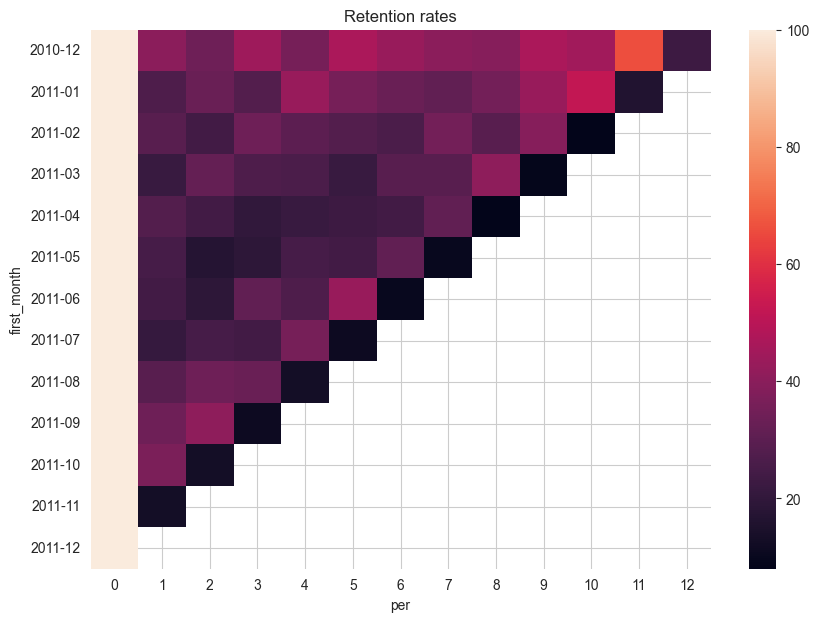

In [865]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot()
sns.heatmap(piv)
plt.title('Retention rates')
plt.show()

Let's move further and figure out another features.
Here we will use not modified initiall dataset. 

In [298]:
df1 = pd.read_excel('/Users/vladimiregorov/Downloads/Online Retail 2.xlsx')

Let's see the distribution of `hour`

<Axes: >

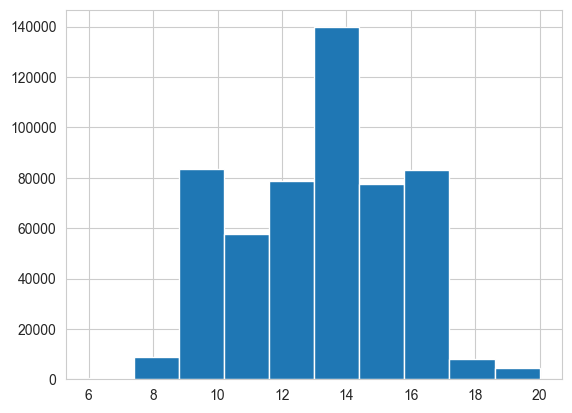

In [867]:
df1['hour'] = df1['InvoiceDate'].dt.hour
df1['hour'].hist()

Now let's figure out the amount of orders per each hour : 

<Axes: xlabel='hour'>

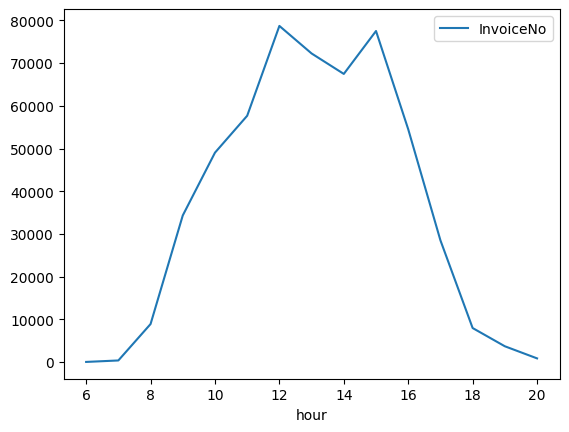

In [319]:
df1.groupby('hour').agg({'InvoiceNo' : 'count'}).plot()

Lets calculate the total amount for each order an analyze the mean amount money people spend per each hour

In [911]:
df1['total'] = df1['UnitPrice'] * df1['Quantity']
exp = df1.groupby('InvoiceNo').agg({'total' : 'sum'}).reset_index()
df1 = df1.merge(exp, how='left', left_on='InvoiceNo', right_on='InvoiceNo')
df1.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,hour,total_x,total_y
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,8,15.30,139.12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,8,20.34,139.12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,8,22.00,139.12


In [913]:
df1 = df1.rename(columns=({'total_x' : 'total', 'total_y' : 'total_ord'}))
df1.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,hour,total,total_ord
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,8,15.30,139.12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,8,20.34,139.12


In [915]:
mean_rev = df1.groupby('hour').agg({'total_ord': 'mean'}).reset_index()

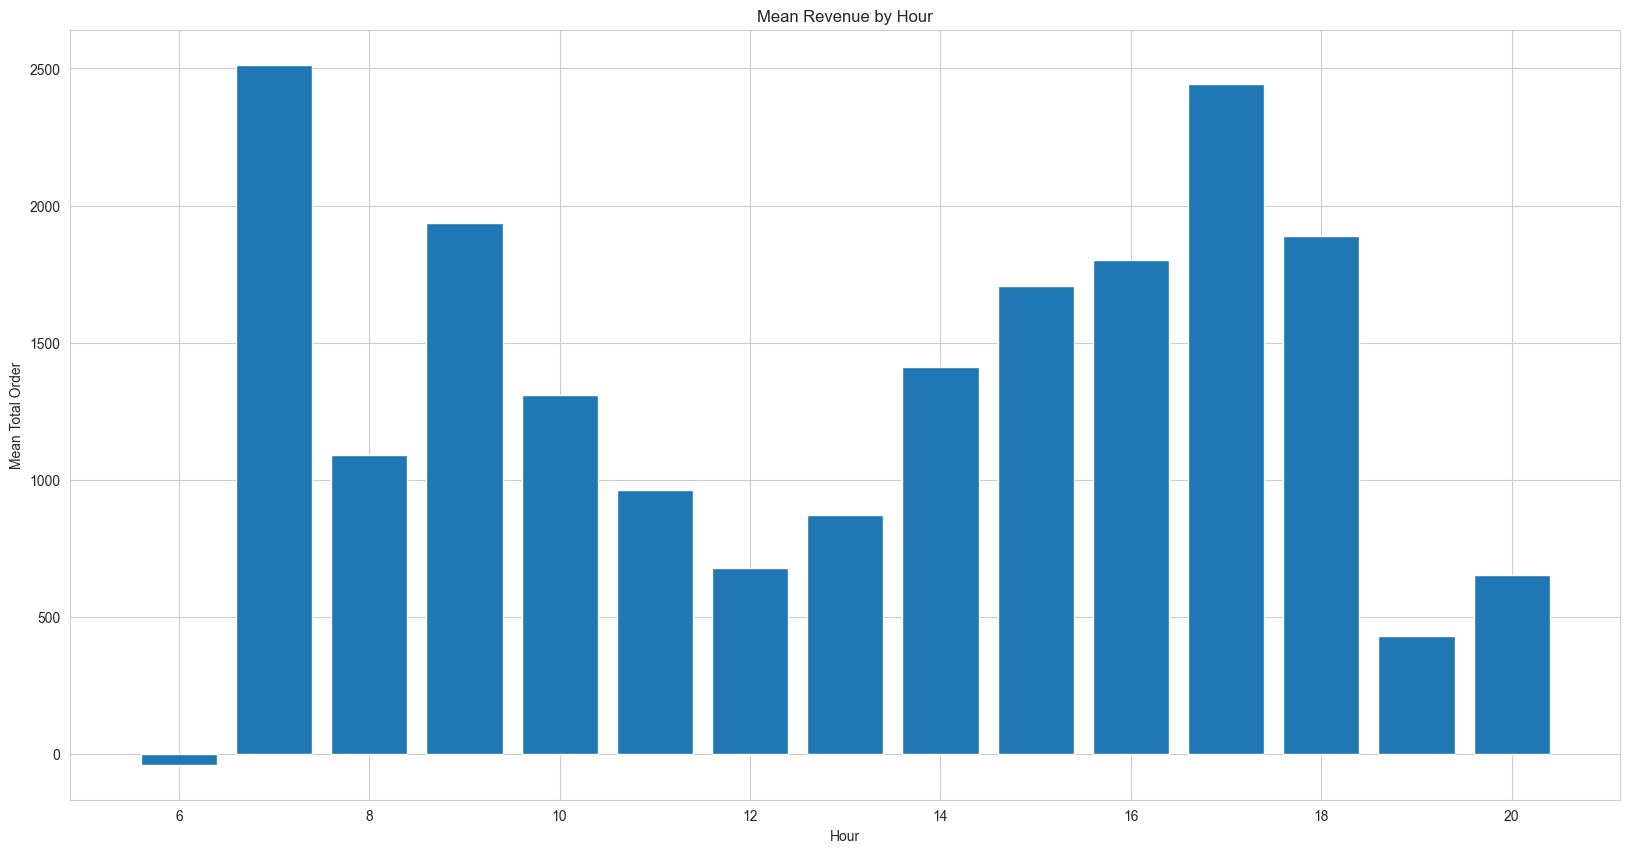

In [917]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()

x = mean_rev['hour']
y = mean_rev['total_ord']

plt.bar(x, y)

plt.title('Mean Revenue by Hour')
plt.xlabel('Hour')
plt.ylabel('Mean Total Order')
plt.grid(True)

plt.show()

One more thing. We want to find out the most populat goods per each hour. Let's find out : 

In [918]:
data = df1.groupby(['hour', 'StockCode']).agg({'StockCode' : 'count'})
data = data.rename(columns=({'StockCode' : 'quntity'})).reset_index()
data.head(3)

,hour,StockCode,quntity
0,6,21216,1
1,6,21218,1
2,6,21314,1


In [919]:
def f(group):
    return group.nlargest(3, 'quntity')

data = data.groupby('hour', group_keys=False).apply(f)
data.head()

/var/folders/t9/p_t5rsf92s38bb58_mfpk3rm0000gn/T/ipykernel_56800/1174805563.py:4: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,hour,StockCode,quntity
4,6,21845,2
17,6,22729,2
24,6,22847,2
147,7,22423,4
75,7,21523,3


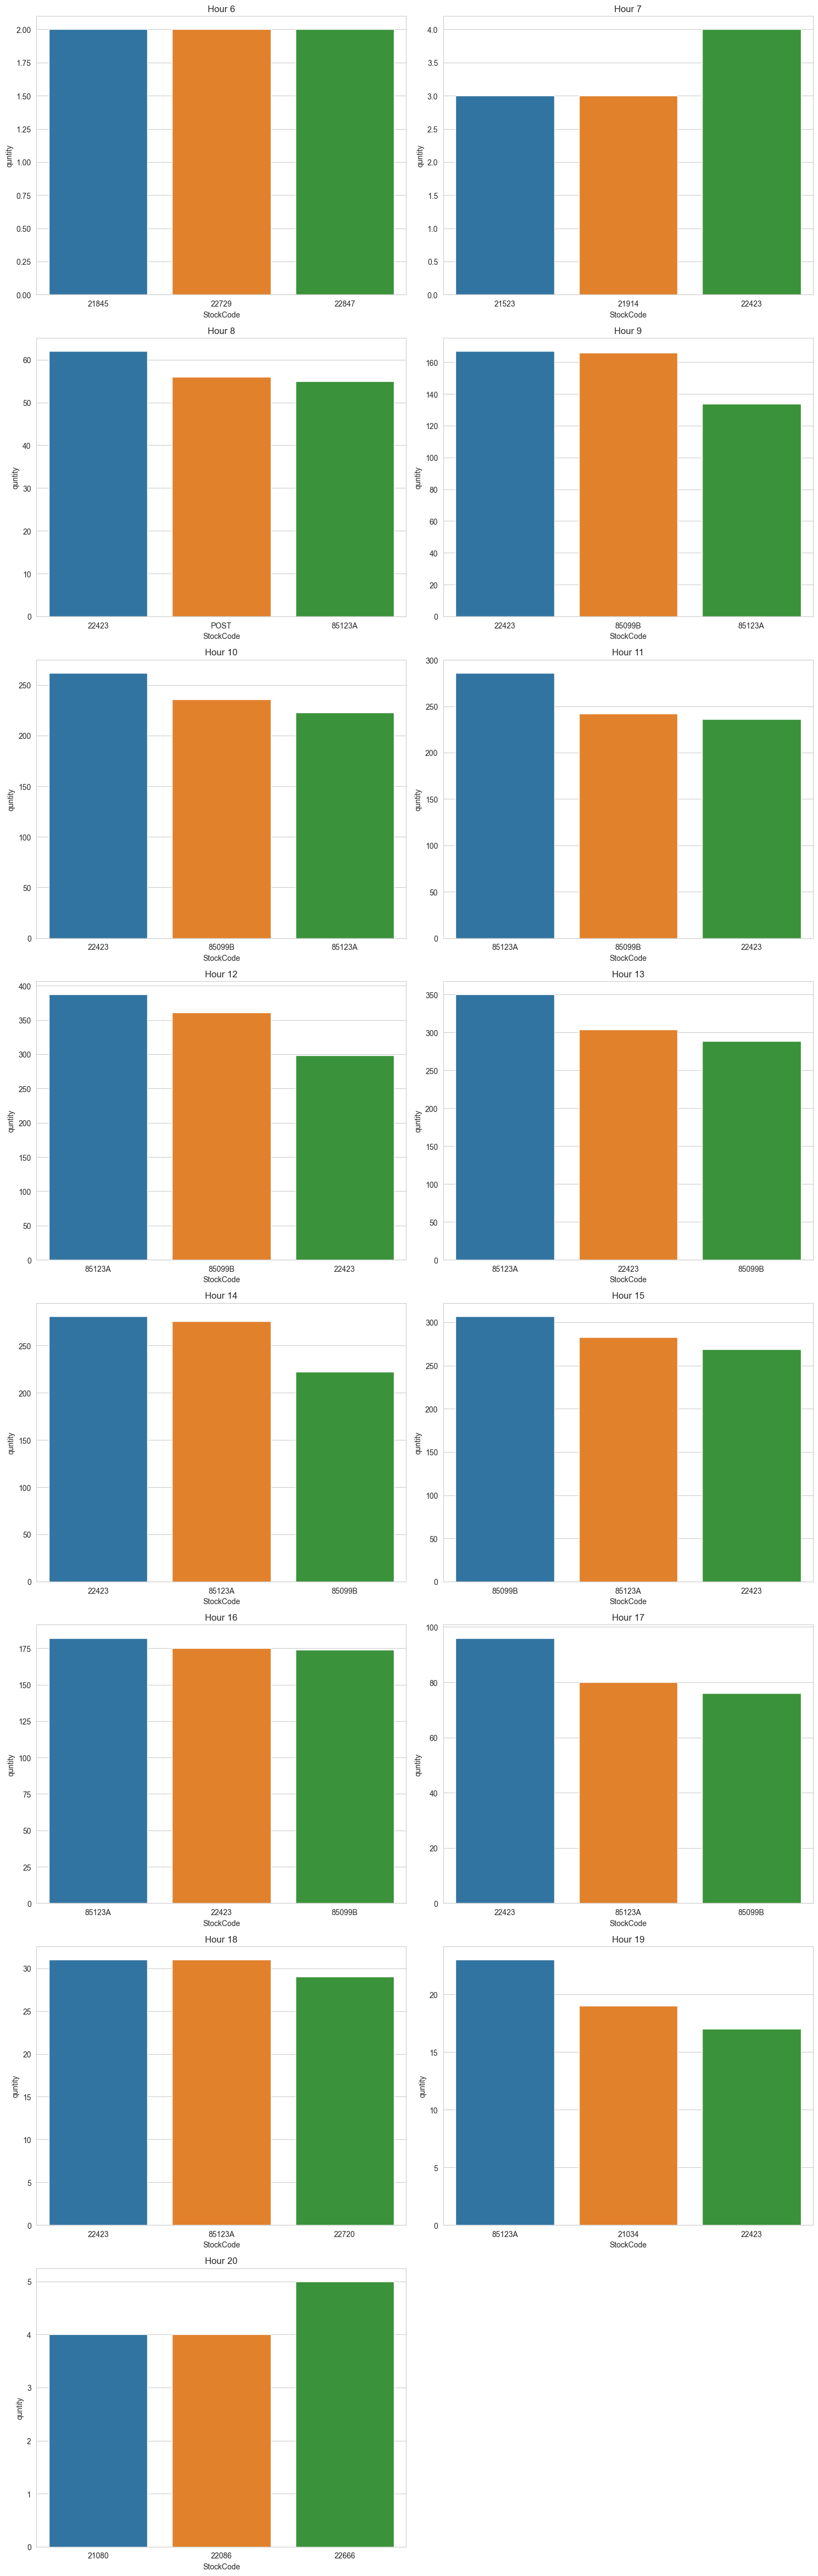

In [922]:
fig = plt.figure(figsize=(15, 47))  

grouped_data = data.groupby('hour')

num_rows = len(grouped_data) // 2 + (1 if len(grouped_data) % 2 != 0 else 0) 

for i, (hour, group) in enumerate(grouped_data, 1):
    ax = fig.add_subplot(num_rows, 2, i)  
    sns.barplot(x='StockCode', y='quntity', data=group, ax=ax)
    ax.set_title(f'Hour {hour}')

fig.tight_layout()

plt.show()


Great, let's move to the `ml` part!

## RFM ANALYSIS

Let's make an RFM analysis. This is ML problem, clustering one.

In [795]:
from sklearn.neighbors import LocalOutlierFactor
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import LocalOutlierFactor
import plotly.express as px

In next lines of code i will create the table which will contain following columns : 
- `Frequency`- the quantity of orders made by each client
- `Recency` - the quantitty of days have passed since the last order has been made
- `Monetary` - the sum of all orders (money) made by each client

In [976]:
data = df1.groupby('CustomerID').agg({'InvoiceNo' : 'count'}).reset_index()
data = data.rename(columns=({'InvoiceNo' : 'Quantity'}))

data2 = df1.groupby('CustomerID').agg({'InvoiceDate' : 'max'}).reset_index()
data2 = data2.rename(columns=({'InvoiceDate' : 'lastdata'}))

data = data.merge(data2)

maxdata = data['lastdata'].max()
maxdata = pd.to_datetime(maxdata)
maxdata = datetime.strftime(maxdata, '%Y-%m-%d')
maxdata = datetime.strptime(maxdata, '%Y-%m-%d')

data['lastdata'] = data['lastdata'].apply(lambda x: datetime.strftime(x, '%Y-%m-%d'))
data['lastdata'] = data['lastdata'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
data['diff'] = maxdata - data['lastdata']


data3 = df1.groupby('CustomerID').agg({'total' : 'sum'}).reset_index()
data = data.merge(data3)

data = data.rename(columns=({'diff' : 'Recency', 'Quantity' : 'Frequency', 'total' : 'Monetary'}))

data = data.drop(columns=('lastdata'))
data = data.drop(columns=('CustomerID'))

data['Recency'] = data['Recency'].dt.days

Finally, here is our table : 

In [978]:
data.head()

,Frequency,Recency,Monetary
0,2,325,0.00
1,182,2,4310.00
2,31,75,1797.24
3,73,18,1757.55
4,17,310,334.40


Allright, let's move to ML part, but firstly let's plot the dependensis if each column to each other and understand if there are some `outliers`

/opt/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



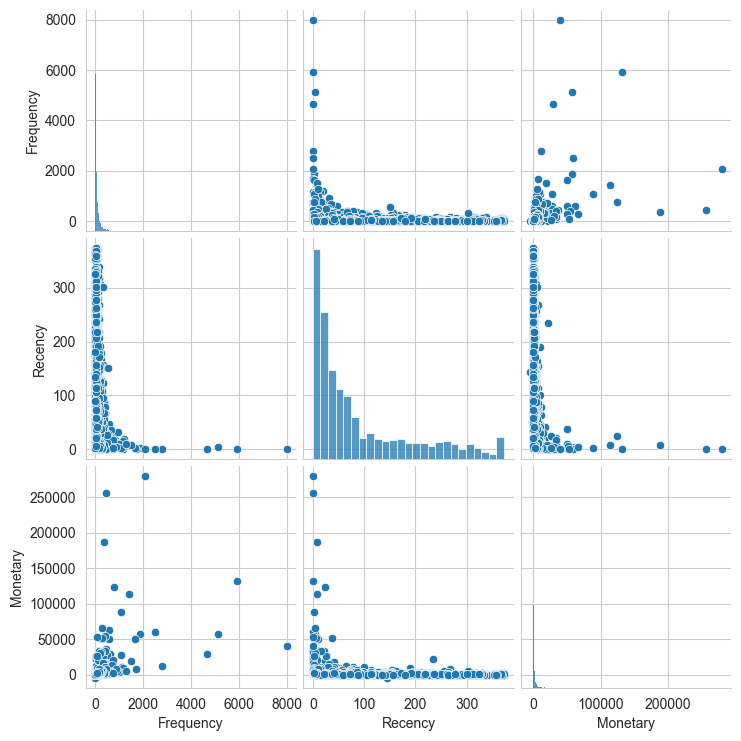

In [979]:
sns.pairplot(data[['Frequency','Recency','Monetary']])

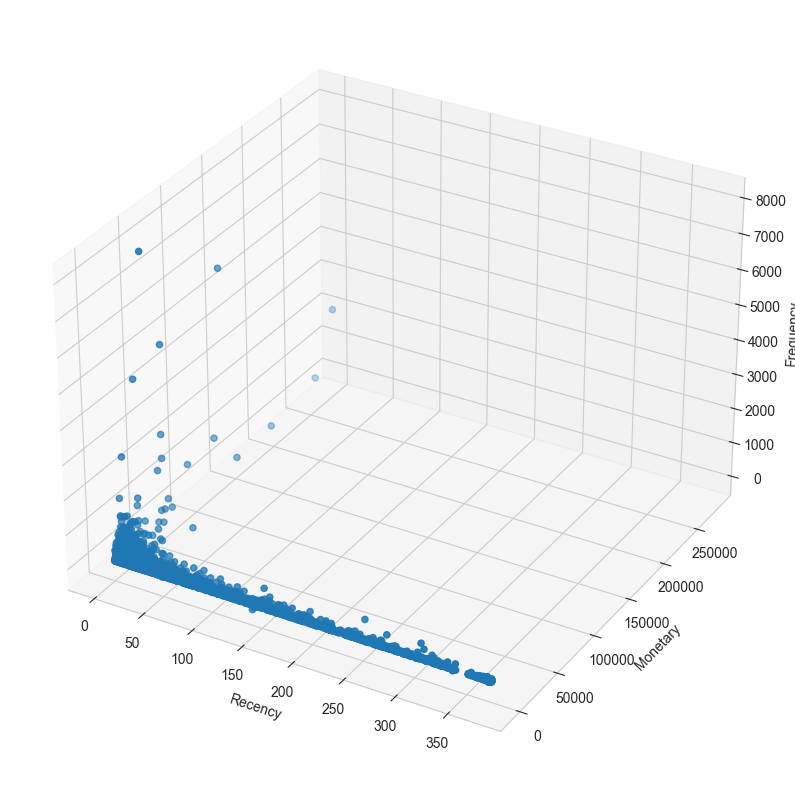

In [980]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(data['Recency'], data['Monetary'], data['Frequency'])
ax.set_xlabel('Recency')
ax.set_ylabel('Monetary')
ax.set_zlabel('Frequency')

plt.show()

We can make the conclusion that `there are some outliers` in the data that might have a `huge negative influence` on the ml models. So, let's get rid of them : 

In [981]:
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
outliers = lof.fit_predict(data)
outliers_indices = data[outliers == -1].index
data_clean = data.drop(outliers_indices)

/opt/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



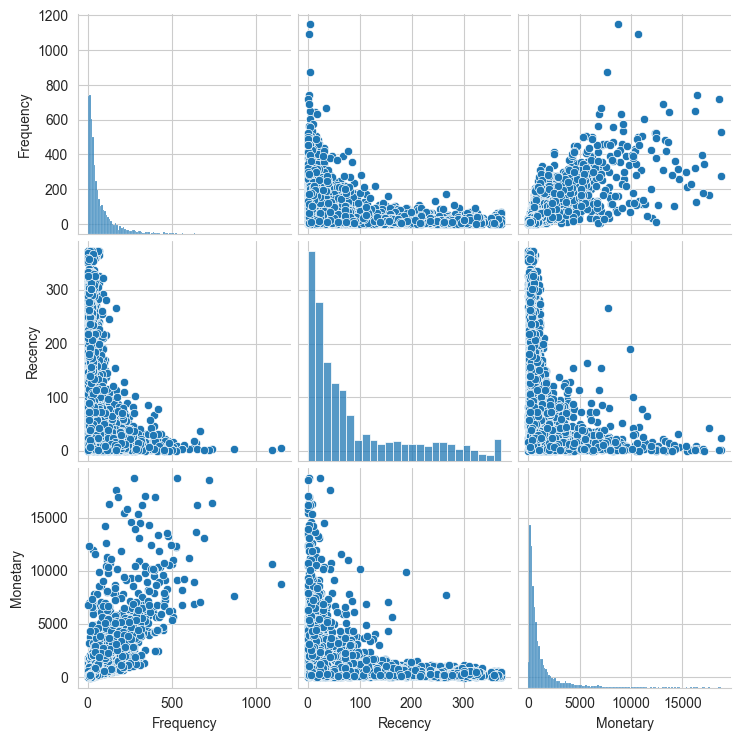

In [982]:
sns.pairplot(data_clean[['Frequency','Recency','Monetary']])

Awesome, let's also scale the data : 

In [983]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_clean[['Recency', 'Frequency', 'Monetary']])

Great, firstly let's use `DBSCAN` model. After that we will use `KMeans`.

In [987]:
dbscan = DBSCAN(eps=0.5, min_samples=3)
data_clean['Cluster'] = dbscan.fit_predict(X_scaled)

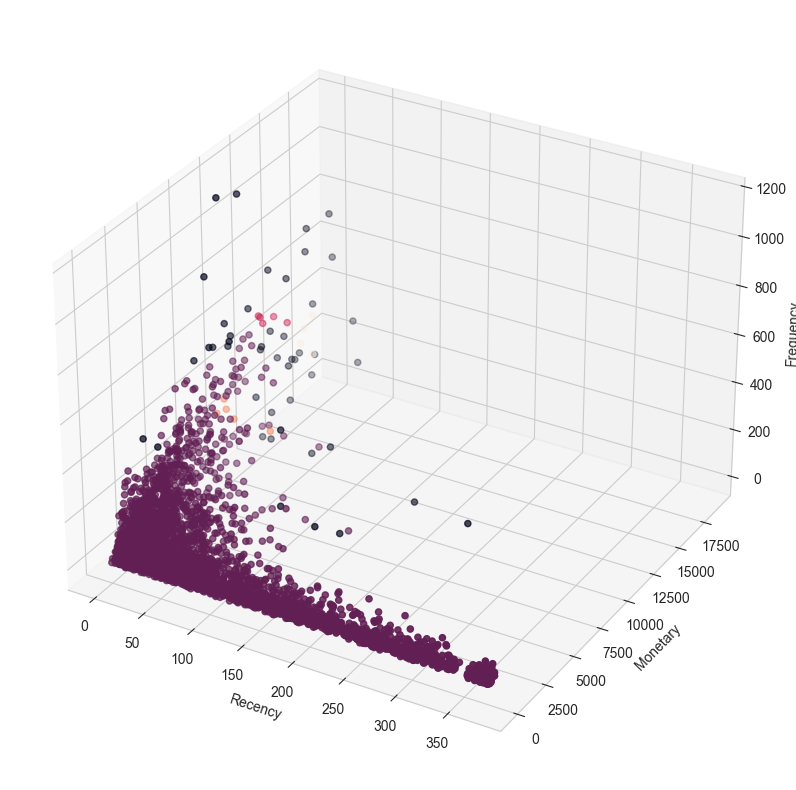

In [988]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(data_clean['Recency'], data_clean['Monetary'], data_clean['Frequency'], c=data_clean['Cluster'])
ax.set_xlabel('Recency')
ax.set_ylabel('Monetary')
ax.set_zlabel('Frequency')

plt.show()

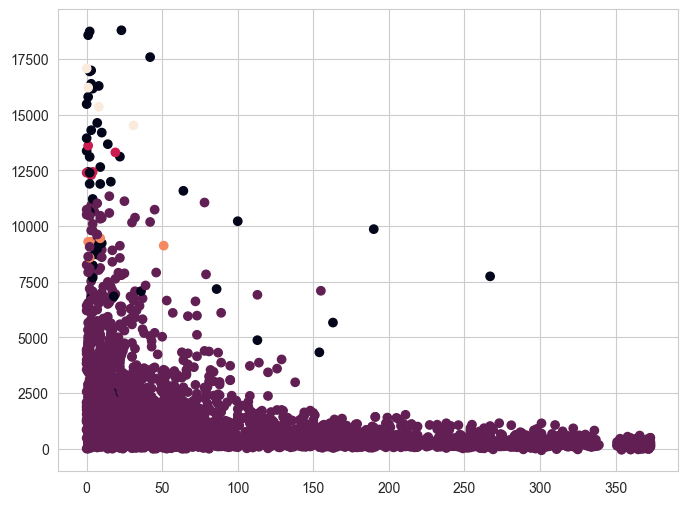

In [989]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot()
ax.scatter(data_clean['Recency'], data_clean['Monetary'],c=data_clean['Cluster'])

Seems not too good, let's see the KMeans model. But before constructing the model let's look up to `Elbow` and `silhouette_score` to understand how many clusters do we need

In [990]:
inertias = []
K_range = range(1, 10)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_clean)
    inertias.append(kmeans.inertia_)

In [991]:
results = []

for i in range(2, 10):
    k = i
    kmeans = KMeans(n_clusters=k, random_state=42)
    data_clean['Cluster'] = kmeans.fit_predict(data_clean)  
    silhouette_avg = silhouette_score(data_clean, data_clean['Cluster'])  
    results.append((silhouette_avg)) 

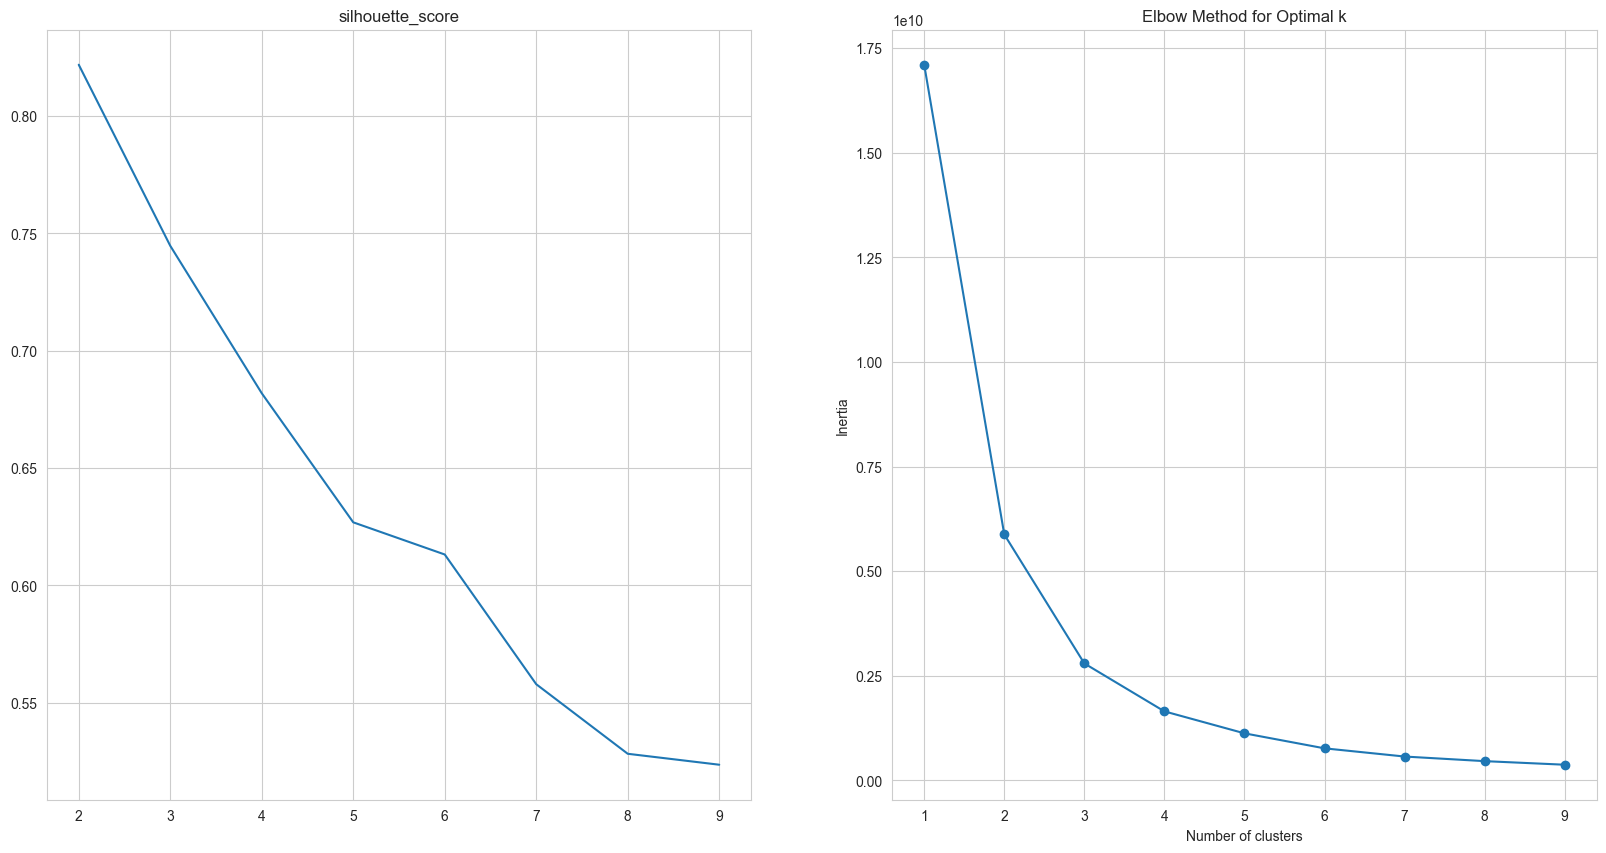

In [992]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,2,1)
x = [2,3,4,5,6,7,8,9]
y = results
plt.plot(x,y)
plt.title('silhouette_score')

ax = fig.add_subplot(1,2,2)
plt.plot(K_range, inertias, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')

plt.show()

Well, here we might say that the optimal number of clusters is `3`. 

Lets predict our clusters and plot the graphs : 

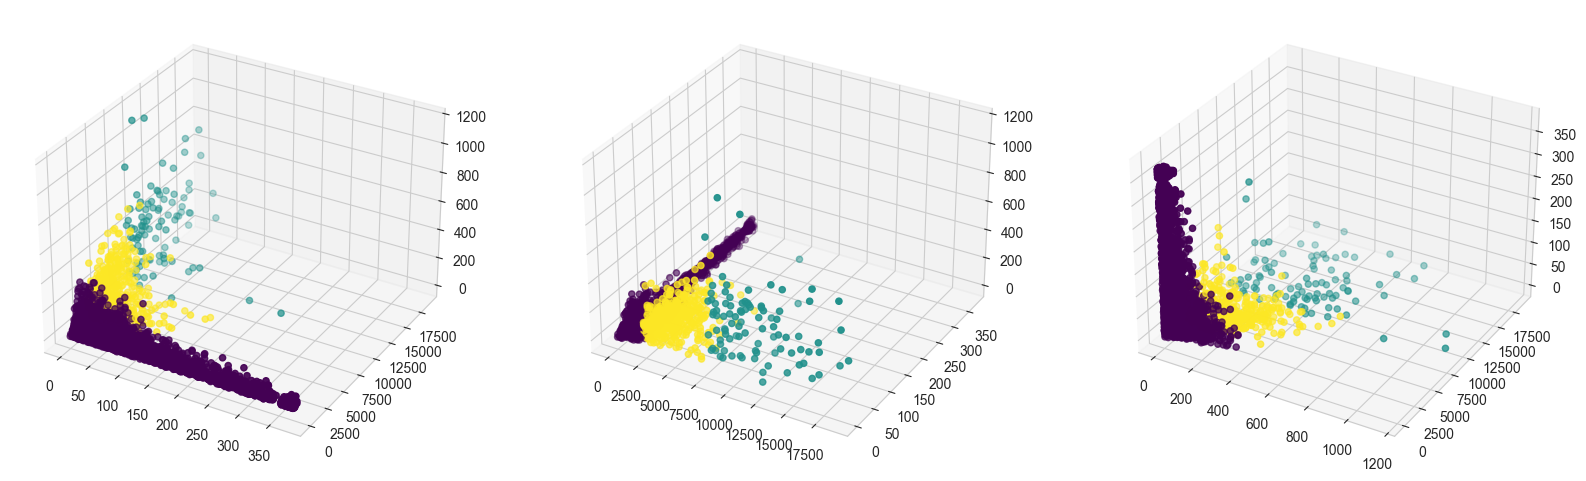

In [970]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
data_clean['Cluster'] = kmeans.fit_predict(data_clean)



fig = plt.figure(figsize=(20, 10))

ax = fig.add_subplot(131, projection='3d')
ax.scatter(data_clean['Recency'], data_clean['Monetary'], data_clean['Frequency'], c=data_clean['Cluster'], cmap='viridis')


ax = fig.add_subplot(132, projection='3d')
ax.scatter(data_clean['Monetary'],data_clean['Recency'], data_clean['Frequency'], c=data_clean['Cluster'], cmap='viridis')


ax = fig.add_subplot(133, projection='3d')
ax.scatter( data_clean['Frequency'],data_clean['Monetary'],data_clean['Recency'], c=data_clean['Cluster'], cmap='viridis')


plt.show()


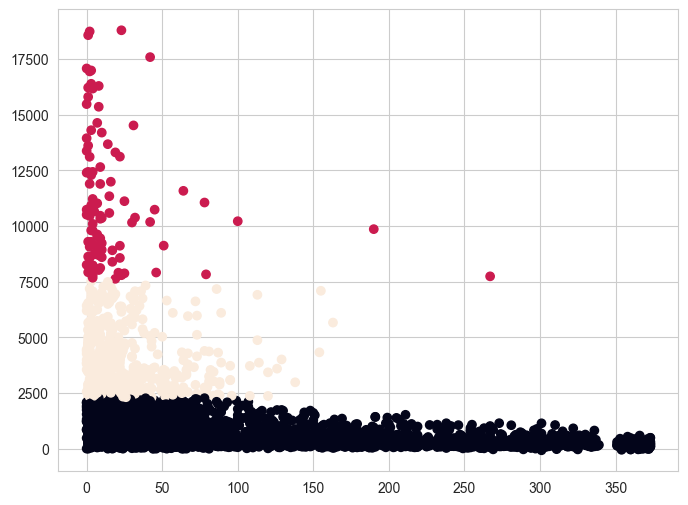

In [960]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot()
ax.scatter(data_clean['Recency'], data_clean['Monetary'],c=data_clean['Cluster'])

great, it's much better!

# To be continued

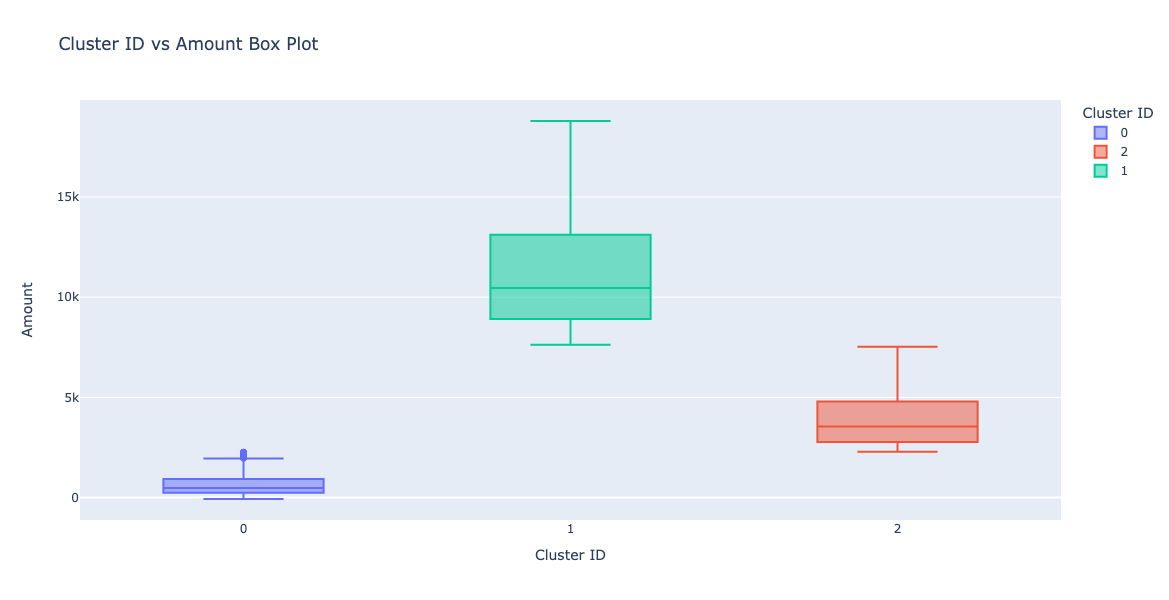

In [807]:
fig = px.box(data_clean, x='Clusters', y='Monetary',
             title="Cluster ID vs Amount Box Plot",
             labels={'Clusters': 'Cluster ID', 'Monetary': 'Amount'}, color = 'Clusters')


fig.update_layout(width=800, height=600)

fig.show()